# Approximating Option Greeks
Mack Shaughnessy

* [Introduction](#first-bullet)
* [Implementing in a Class](#second-bullet)
* [A Closer Look Through Extension of The Class](#third-bullet)
* [Comparison With Analytical Solution](#fourth-bullet)
* [Works Cited](#fifth-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>
This notebook shows how option greeks can be approximated using partial derivatives of the the Black-Scholes equation. We will see that the approximations are easy to implement and accurate when compared to an analytical solution. However, the anlytical solutions for each of these greeks are widely available, often other models are used rather than the Black-Scholes, and the partial derivative method doesn't offer a speed advantage.  The strength of this method lies in it's potential for generalization to other equations where an analytical solution is not easily obtainable.  For any equation or model that is implemented in a function such that the arguments are taken as a list, the partial derivative method can be used.  

Each greek is a risk metric which describes the relationship between the price of an option (or one of the other greeks) and an input used to calculate that price (or greek).  We will look at:
* **Delta:** rate of change between an option's price and a change in the underlying asset's price.
* **Gamma:** rate of change between an option's delta and the underlying asset's price.
* **Theta:** rate of change between the option's price and time to expiration.
* **Vega:** rate of change between the option's price and underlying asset's volatility.
We can think of each of these greeks as the partial derivative of the equation with respect to the input.

We will create a class that prices a non-dividend paying, european option using Black-Scholes and approximates the greek value. The approximation will rely on a partial derivative function from the nlib library, shown below. [1]

In [1]:
def partial(f,i,h=1e-4):
    def df(x,f=f,i=i,h=h):
        x = list(x) # make copy of x
        x[i] += h
        f_plus = f(x)
        x[i] -= 2*h
        f_minus = f(x)
        if isinstance(f_plus,(list,tuple)):
            return [(f_plus[i]-f_minus[i])/(2*h) for i in xrange(len(f_plus))]
        else:
            return (f_plus-f_minus)/(2*h)
    return df

This is a functional that takes a function with a list argument and returns a function which can evaluate the partial derivative at a given point.  We specify the argument for which the derivative will be with respect to. Here is a quick example of how the function works:
For the function $f(x) = 2x + 3y + 5yz$, $\frac{\partial f}{\partial z}$ would be evaluated analytically as
$\frac{\partial f}{\partial y} = 3 + 5z$
and if ${x,y,z} = {1,1,1}$ then $\frac{\partial f}{\partial y} = 8$

Implementing this into code:

In [2]:
def example_function(x):
    return 2*x[0] + 3*x[1] + 5*x[1]*x[2]

# specify the index 1 argument, or the "y"
example_partial = partial(example_function,1)

# the arguments
x = (1,1,1)

# the the partial derivative evalutated at (1,1,1)
round(example_partial(x),1)

8.0

## Implementing in a Class <a class="anchor" id="second-bullet"></a>
To approximate the greeks, the partial function will be applied the Black-Scholes equation. These calculations are implemented in the class below.

In [3]:
from scipy.stats import norm 
from math import sqrt, exp, log
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

class Black_Scholes:
    
    def __init__(self, parameters):
        # make sure parameters are floats
        self.parameters = map(float, parameters)
    
    # call price function
    # doesnt compute option value, so that the partial derivative can be taken
    # from the function
    def call_price_fx(self, x):
        # set parameters of equation
        S0 = x[0] # underlying
        K = x[1] # strike
        r = x[2] # return
        sigma = x[3] # volatility
        T = x[4] # time to expiration
        # find d1 and d2
        d1 = (log(S0/K) + (r + sigma**2/2)*T) / (sigma * sqrt(T))
        d2 = d1 - sigma*sqrt(T)
        # find call price c
        c = S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
        return c
    
    # value of call option
    def call_price(self):
        # get parameters
        x = self.parameters
        c = self.call_price_fx(x)
        return c
    
    # call option greeks
    def c_delta(self):
        x = self.parameters
        delta = partial(self.call_price_fx, 0)
        return delta(x)
    
    def c_theta(self):
        x = self.parameters
        theta = partial(self.call_price_fx, 4)
        return -theta(x)
    
    def c_gamma(self):
        x = self.parameters
        delta = partial(self.call_price_fx, 0)
        gamma = partial(delta, 0) # second partial derivative..partial of delta
        return gamma(x)
    
    # put price function
    def put_price_fx(self, x):
        # set parameters of equation
        S0 = x[0] # underlying
        K = x[1] # strike
        r = x[2] # return
        sigma = x[3] # volatility
        T = x[4] # time to expiration
        # find d1 and d2
        d1 = (log(S0/K) + (r + sigma**2/2)*T) / (sigma * sqrt(T))
        d2 = d1 - sigma*sqrt(T)
        # find put price p
        p = K*exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
        return p
    
    def put_price(self):
        x = self.parameters
        p = self.put_price_fx(x)
        return p
    
    # put option greeks
    def p_delta(self):
        x = self.parameters
        delta = partial(self.put_price_fx, 0)
        return delta(x)
    
    def p_theta(self):
        x = self.parameters
        theta = partial(self.put_price_fx, 4)
        return -theta(x)
    
    def p_gamma(self):
        x = self.parameters
        delta = partial(self.put_price_fx, 0)
        gamma = partial(delta, 0)
        return gamma(x)

For a put option where the underlying price is $\$40$, strike price is $\$50$, daily expected return is $.001$, daily volatility is $.03$, and days to expiration is $90$:

In [4]:
put = Black_Scholes((40, 50, .001, .03, 90))
put_price = round(put.put_price(),2)
put_delta = round(put.p_delta(),2)
print 'the price of the put is ',put_price,' and the delta is ',put_delta

the price of the put is  8.21  and the delta is  -0.63


We can compare a put and call option with the same paramters as the price of the underlying moves from $\$1$ past the strike price of $\$50$ to $\$100$.

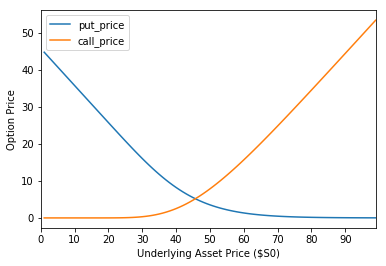

In [5]:
S0,c0,p0 = [],[],[]
for i in range(1,100):
    params = [i, 50, .001, .03, 90]
    option = Black_Scholes(params)
    S0.append(i)
    c0.append(option.call_price())
    p0.append(option.put_price())

pc_df = pd.DataFrame({'stock_price' : S0,
                      'put_price' : p0,
                      'call_price' : c0})

pc_df.plot(x = 'stock_price',
           y = ['put_price','call_price'],
           xticks = range(0,100,10)
          ).set(xlabel = 'Underlying Asset Price ($S0)', ylabel = 'Option Price'); #semicolon suppresses console output for chart

## A Closer Look Through Extension of the Class <a class="anchor" id="third-bullet"></a>
Let's have a closer look at how the greeks are approximated by extending the class to include vega.

Vega is expressed as $\frac{\partial V}{\partial \sigma}$, so it is the partial derivative of the equation with respect to sigma. In the method below, the partial function is applied to the third component of the Black-Scholes equation which is the sigma component of our implementation.

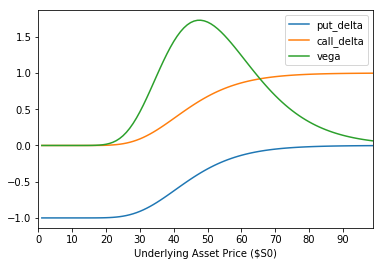

In [6]:
# extend the class to include vega
class Black_Scholes_w_Vega(Black_Scholes):
    # call option vega
    def c_vega(self):
        x = self.parameters
        vega = partial(self.call_price_fx, 3)
        return vega(x)*.01
    # put option vega
    def p_vega(self):
        x = self.parameters
        vega = partial(self.call_price_fx, 3)
        return vega(x)*.01

# chart vega with put and call delta
delt_c, delt_p, vega, S0 = [],[],[],[]

for i in range(1,100):
    params = [i, 50, .001, .03, 90] #i, 50, .001, .03, 90 #i, 50, .05, .2, .3846
    option = Black_Scholes_w_Vega(params)
    S0.append(i)
    delt_c.append(option.c_delta())
    delt_p.append(option.p_delta())
    vega.append(option.c_vega())

cpdv_df = pd.DataFrame({'stock_price' : S0,
                        'put_delta' : delt_p,
                        'call_delta' : delt_c,
                        'vega' : vega})

cpdv_df.plot(x = 'stock_price',
             y = ['put_delta','call_delta', 'vega'],
             xticks = range(0,100,10)
            ).set(xlabel = 'Underlying Asset Price ($S0)');    

## Comparison with an Analytical Solution <a class="anchor" id="fourth-bullet"></a>
Let's check on the approximation by finding an analytical solution for vega and comparing the results. We will borrow an example from "Options, Futures, and Other Derivatives" [2] and use annualized inputs. Our new inputs become:
* underlying $\$49$
* strike $\$50$
* return or risk-free $5\%$
* expiration $20$ weeks or $.3846$ years
* volatility $5\%$

In [7]:
# analytical solution for vega
def analytical_vega(S0, K, r, sigma, T):
    d1 = (log(S0/K) + (r + sigma**2/2)*T) / (sigma * sqrt(T))
    vega = S0*sqrt(T)*norm.pdf(d1)*.01 #prob density fx not cumulative
    return vega

analytical_result = analytical_vega(49.0, 50.0, .05, .2, .3846)

# approximate solution for vega
approx = Black_Scholes_w_Vega([49, 50, .05, .2, .3846])
approx_result = approx.c_vega()

# compare
delta = abs(approx_result - analytical_result)
print 'approximated result is ',round(approx_result,3), ', analytical result is ',round(analytical_result,3),', and difference is ', delta


approximated result is  0.121 , analytical result is  0.121 , and difference is  2.03436573143e-11


A plot of the greeks we havent looked at yet, gamma and theta.

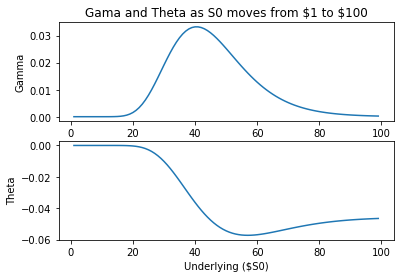

In [8]:
S0,gamma, theta = [],[],[]
for i in range(1,100):
    params = [i, 50, .001, .03, 90]
    option = Black_Scholes(params)
    S0.append(i)
    gamma.append(option.c_gamma())
    theta.append(option.c_theta())

plt.subplot(2,1,1)
plt.plot(S0, gamma)
plt.title('Gama and Theta as S0 moves from \$1 to \$100')
plt.ylabel('Gamma')
plt.subplot(2,1,2)
plt.plot(S0, theta)
plt.ylabel('Theta')
plt.xlabel('Underlying (\$S0)');

## Works Cited <a class="anchor" id="fifth-bullet"></a>
[1] https://github.com/mdipierro/nlib

[2] John C. Hull and Sankarshan Basu, "Options, Futures, and Other Derivatives", Eighth Edition, p. 419 